# PARTE 3: ANÁLISE PREDITIVA DOS DADOS

## Alunos: Ana Carolina Wagner e José Valentim
## Mestrado FGV-EMAp - 2018.1
## MMD - Prof. Renato

# Kaggle - TalkingData AdTracking Fraud Detection Challenge

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

___

## Considerações

* Trata-se de um problema de **classificação binária** - ou seja, nossa variável alvo é um atributo binário (o usuário está tornando o clique fraudulento ou não?);


* O objetivo é classificar os usuários em "fraudulentos" ou "não fraudulentos". Ou ainda, estamos tentando prever downloads após cliques ou não.
____

## Fontes

* https://www.kaggle.com/graf10a/pranav-s-lgbm-lb-0-9699?scriptVersionId=3073843/code

* https://www.kaggle.com/pranav84/talkingdata-count-features-and-animations

* https://www.kaggle.com/nanomathias/feature-engineering-importance-testing

* https://www.kaggle.com/asraful70/feature-engineering-of-talkingdata-with-lightgbm

## 1. Carregando bibliotecas

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import os
import csv
import time
import datetime
import itertools
import gc # garbage collection 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

path = '../../../../../dados/Dados/Kaggle/' # Servidor - Renato 
path_ana = os.getcwd()

## 2. Importando os dados

In [2]:
# Data Types - reduzir o espaço de armazenamento usando inteiros onde possível
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'day'           : 'uint8',
        'hour'          : 'uint8'
        }

In [3]:
# Importando Apenas As Colunas Selecionadas
train_cols = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'is_attributed']
test_cols  = ['ip', 'app', 'device', 'os', 'channel', 'click_time']

In [4]:
# Conjunto de Treinamento
start_time = time.time()
df_train = pd.read_csv(path_ana + "/datasets/train_sample_10_reduced.csv", dtype=dtypes, usecols = train_cols)
print('{} seconds to load df_train'.format(time.time() - start_time))

18.784009218215942 seconds to load df_train


In [5]:
df_train.head()

,ip,app,device,os,channel,day,hour,is_attributed
0,35810,3,1,13,379,6,14,0
1,165970,3,1,13,379,6,14,0
2,111385,3,1,18,379,6,14,0
3,74715,3,1,19,379,6,14,0
4,148454,3,1,19,379,6,14,0


In [6]:
# Conjunto Teste
start_time = time.time()
df_test = pd.read_csv(path + "test.csv", dtype=dtypes, usecols = test_cols)
print('{} seconds to load df_test'.format(time.time() - start_time))

21.476465463638306 seconds to load df_test


In [9]:
# Convertendo 'click_time' Para Série Temporal
df_test['click_time'] = pd.to_datetime(df_test['click_time'])

# Criando novas features a partir de 'click_time'
df_test["day"], df_test["hour"] = zip(*df_test["click_time"].apply(lambda row: (row.day, row.hour)))
df_test = df_test.drop(['click_time'], axis=1)   

# Salvando 
#pickle.dump(df_test, open("df_test.p", "wb"), protocol=4)
# Carregando 
df_test = pickle.load(open("df_test.p", "rb"))

In [10]:
df_test.head()

,ip,app,device,os,channel,day,hour
0,5744,9,1,3,107,10,4
1,119901,9,1,3,466,10,4
2,72287,21,1,19,128,10,4
3,78477,15,1,13,111,10,4
4,123080,12,1,13,328,10,4


## 3. *Feature engineering*

### 3.1. Contagem dos cliques das *features* ip, app, os e channel

In [45]:
train_index = df_train.shape[0]

# Extraindo o atributo alvo
y_train = df_train['is_attributed']
df_train = df_train.drop(['is_attributed'], axis=1)

# Fazendo um merge do conjunto de treinamento com o conjunto teste
df_merge = pd.concat([df_train, df_test])

# Limpando a memória
del df_train, df_test
gc.collect()

In [18]:
columns = ['ip', 'app', 'os', 'channel']

for col in columns:
    df_count = df_merge[col].value_counts().reset_index(name='clicks_by_' + col)
    df_count.columns = [col, 'clicks_by_' + col]
    df_merge = df_merge.merge(df_count, on=col, how='left', sort=False)
    df_merge['clicks_by_' + col] = df_merge['clicks_by_' + col].astype('uint16')
    del df_count
    gc.collect()

In [19]:
df_train = df_merge[:train_index]
df_test = df_merge[train_index:]

del df_merge
gc.collect()

0

In [20]:
df_train.head()

,ip,app,device,os,channel,day,hour,clicks_by_ip,clicks_by_app,clicks_by_os,clicks_by_channel
0,35810,3,1,13,379,6,14,2128,18761,7354,24753
1,165970,3,1,13,379,6,14,241,18761,7354,24753
2,111385,3,1,18,379,6,14,638,18761,64121,24753
3,74715,3,1,19,379,6,14,299,18761,33570,24753
4,148454,3,1,19,379,6,14,571,18761,33570,24753


### 3.2. Agrupamentos de algumas *features*

In [25]:
# Fazendo um merge do conjunto de treinamento com o conjunto teste
df_merge = pd.concat([df_train, df_test])

# Limpando a memória
del df_train, df_test
gc.collect()

48

In [29]:
# Número de cliques associados a um determinado IP em cada hora (ip_day_hour)
df_count = df_merge[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_day_hour'})
df_merge = df_merge.merge(df_count, on=['ip','day','hour'], how='left')
del df_count
gc.collect()

# Número de cliques associados a um determinado IP e aplicativo (ip_app)
df_count = df_merge[['ip','app', 'channel']].groupby(by=['ip','app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app'})
df_merge = df_merge.merge(df_count, on=['ip', 'app'], how='left')
del df_count
gc.collect()

# Número de cliques associados a um determinado IP, aplicativo e sistema operacional (ip_app_os)
df_count = df_merge[['ip','app', 'os', 'channel']].groupby(by=['ip','app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os'})
df_merge = df_merge.merge(df_count, on=['ip', 'app', 'os'], how='left')
del df_count
gc.collect()

107

In [34]:
df_train = df_merge[:train_index]
df_test = df_merge[train_index:]

# Salvando 
pickle.dump(df_train, open("df_train_2.p", "wb"), protocol=4)
pickle.dump(df_test, open("df_test_2.p", "wb"), protocol=4)

del df_merge
gc.collect()

In [32]:
df_train.head()

,ip,app,device,os,channel,day,hour,clicks_by_ip,clicks_by_app,clicks_by_os,clicks_by_channel,ip_day_hour,ip_app,ip_app_os
0,35810,3,1,13,379,6,14,2128,18761,7354,24753,1,320,70
1,165970,3,1,13,379,6,14,241,18761,7354,24753,1,49,4
2,111385,3,1,18,379,6,14,638,18761,64121,24753,1,104,1
3,74715,3,1,19,379,6,14,299,18761,33570,24753,1,42,12
4,148454,3,1,19,379,6,14,571,18761,33570,24753,1,75,19


### 3.3. Adicionando algumas *features* de tempo

In [4]:
# Carregando a feature original click_time para incorporá-la novamente aos dados
click_time_train = pd.read_csv(path_ana + "/datasets/train_sample_10.csv", dtype=dtypes, usecols = ['click_time'])
df_train['click_time'] = click_time_train['click_time']

click_time_test = pd.read_csv(path + "test.csv", dtype=dtypes, usecols = ['click_time'])
df_test['click_time'] = click_time_test['click_time']

In [5]:
# Fazendo um merge do conjunto de treinamento com o conjunto teste
df_merge = pd.concat([df_train, df_test])

In [6]:
df_merge['click_time'] = pd.to_datetime(df_merge['click_time'])

In [7]:
del df_train, df_test
gc.collect()

25

#### nextClick

Vamos adicionar *features* relecionadas ao tempo que leva para o próximo click para um conjunto de agrupamentos das *features* da base.

In [12]:
GROUP_BY_NEXT_CLICKS = [
    
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    #{'groupby': ['ip', 'os']},
    #{'groupby': ['ip', 'app', 'device', 'os', 'channel']}
]

In [13]:
# Calcula o tempo até o próximo clique para cada agrupamento
for spec in GROUP_BY_NEXT_CLICKS:
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    all_features = spec['groupby'] + ['click_time']
    print(spec)
    df_merge[new_feature] = df_merge[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    gc.collect()
pickle.dump(df_merge, open("df_merge.p", "wb"), protocol=4)

{'groupby': ['ip']}


MemoryError: 

In [11]:
gc.collect()

72

## 4. Machine learning

In [3]:
# Iniciando a partir deste ponto!
df_train = pickle.load(open("df_train_2.p", "rb"))
df_test = pickle.load(open("df_test_2.p", "rb"))

y_train = pickle.load(open("y_train.p", "rb"))

#### Importando pacotes para a validação cruzada e avaliação dos modelos

In [4]:
from sklearn import model_selection 

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score 

#### Criando funções para ajudar a avaliar os modelos

In [5]:
# Fonte: https://github.com/rsouza/FGV_Intro_DS/blob/master/notebooks/10-ML_Kaggle_Titanic.ipynb
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Não Baixou', 'Baixou'], normalize=True):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes, normalize=normalize)
    return roc_auc_score(y_true, y_pred)

#### Validação-cruzada (70% treinamento / 30% teste)

Para avaliar o desempenho do modelo antes de fazer a predição, vamos criar um conjunto de validação (30% dos dados de treinamento) no qual podemos mdedir o desempenho do modelo e fazer suposições sobre a generalização em dados não visto (conjunto teste).

In [6]:
X_traincv, X_testcv, y_traincv, y_testcv = model_selection.train_test_split(df_train,
                                                                            y_train,
                                                                            test_size=0.3,
                                                                            random_state=0)

In [7]:
print(X_traincv.shape)
print(X_testcv.shape)
print(y_traincv.shape)
print(y_testcv.shape)

(12941826, 14)
(5546497, 14)
(12941826,)
(5546497,)


#### Selecionando as features

In [8]:
# Selecionando todas as features
all_features = list(X_traincv.columns)
all_features

['ip',
 'app',
 'device',
 'os',
 'channel',
 'day',
 'hour',
 'clicks_by_ip',
 'clicks_by_app',
 'clicks_by_os',
 'clicks_by_channel',
 'ip_day_hour',
 'ip_app',
 'ip_app_os']

In [9]:
# Selecionando apenas as features originais e as novas features de tempo 
base_features = all_features[:7]
base_features

['ip', 'app', 'device', 'os', 'channel', 'day', 'hour']

In [10]:
# Selecionando apenas as novas features de contagem 
count_features = all_features[7:]
count_features

['clicks_by_ip',
 'clicks_by_app',
 'clicks_by_os',
 'clicks_by_channel',
 'ip_day_hour',
 'ip_app',
 'ip_app_os']

### 4.1. Random Forest 

Fontes: 
* https://www.kaggle.com/codeastar/random-forest-classification-on-talkingdata/code

* https://www.kaggle.com/jiegzhan/adtracking-fraud-detection

In [23]:
# Tutotrial: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# Example: https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=13, 
                                criterion='gini', 
                                max_depth=20, 
                                min_samples_split=2,
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None)

#### 4.1.1. Random Forest - Baseline

A primeira ideia é usar o **Random Forest** usando apenas as *features* originais, alterando apenas a `click_time` que foi dropada após a criação das *features* `day` e `hour`.

In [24]:
X_traincv_base = X_traincv[base_features]
X_testcv_base = X_testcv[base_features]

In [25]:
start_time = time.time()
clf_rf_base = clf_rf.fit(X_traincv_base, y_traincv)
print('Train RandomForest df_train with {} seconds'.format(round(time.time() - start_time), 3))

Train RandomForest df_train with 221 seconds


Classification Report
             precision    recall  f1-score   support

 Não Baixou       1.00      1.00      1.00   5532672
     Baixou       0.73      0.36      0.48     13825

avg / total       1.00      1.00      1.00   5546497

ROC Score: 0.6798316365040256
Accuracy Score: 0.9980688712172746
Average Precision Score: 0.26354260952548303
f1 Score: 0.4816840067747399
Normalized confusion matrix
[[9.99663273e-01 3.36726992e-04]
 [6.40000000e-01 3.60000000e-01]]


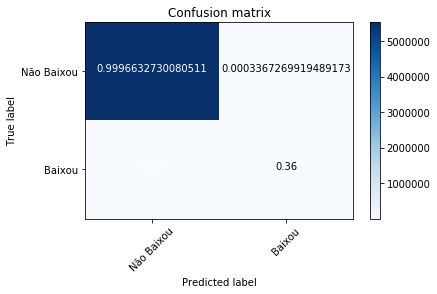

In [29]:
# Avaliando o modelo
roc_rf_base = clf_eval(clf_rf_base, X_testcv_base, y_testcv)

In [30]:
del X_traincv_base, X_testcv_base
gc.collect()

9023

#### 4.1.2. Random Forest - Novas *features* de contagem

Vamos tentar melhorar o modelo **Random Forest** usando apenas as *features* criadas.

In [60]:
X_traincv_count = X_traincv[count_features]
X_testcv_count = X_testcv[count_features]

In [61]:
start_time = time.time()
clf_rf_count = clf_rf.fit(X_traincv_count, y_traincv)
print('Train RandomForest df_train with {} seconds'.format(round(time.time() - start_time), 3))

Train RandomForest df_train with 266 seconds


Classification Report
             precision    recall  f1-score   support

 Não Baixou       1.00      1.00      1.00   5532672
     Baixou       0.77      0.39      0.52     13825

avg / total       1.00      1.00      1.00   5546497

ROC Score: 0.6952998883355942
Accuracy Score: 0.9981961587647122
Average Precision Score: 0.3038005043501139
f1 Score: 0.5192908278479796
Normalized confusion matrix
[[9.99713701e-01 2.86299278e-04]
 [6.09113924e-01 3.90886076e-01]]


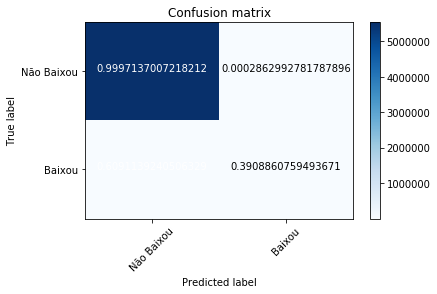

In [62]:
# Avaliando o modelo
roc_rf_count = clf_eval(clf_rf_count, X_testcv_count, y_testcv)

In [115]:
del X_traincv_count, X_testcv_count
gc.collect()

7589

#### 4.1.3. Random Forest - Todas as *features* 

Será que se usarmos todas as *features* conseguimos melhorar o modelo?

In [112]:
X_traincv_all = X_traincv[all_features]
X_testcv_all = X_testcv[all_features]

In [113]:
start_time = time.time()
clf_rf_all = clf_rf.fit(X_traincv_all, y_traincv)
print('Train RandomForest df_train with {} seconds'.format(round(time.time() - start_time), 3))

Train RandomForest df_train with 328 seconds


Classification Report
             precision    recall  f1-score   support

 Não Baixou       1.00      1.00      1.00   5532672
     Baixou       0.74      0.43      0.55     13825

avg / total       1.00      1.00      1.00   5546497

ROC Score: 0.7162705234686338
Accuracy Score: 0.9982170728659909
Average Precision Score: 0.32391471009650374
f1 Score: 0.5476005306738643
Normalized confusion matrix
[[9.99629655e-01 3.70345468e-04]
 [5.67088608e-01 4.32911392e-01]]


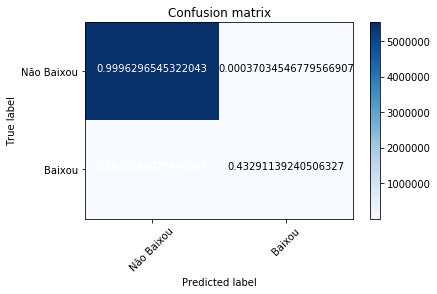

In [114]:
# Avaliando o modelo
roc_rf_all = clf_eval(clf_rf_all, X_testcv_all, y_testcv)

#### Importância das *features*

In [58]:
features = list(X_testcv_all.columns)
df_fi = pd.DataFrame({
                      'clf_rf_all':clf_rf_all.feature_importances_,
                     },
                      index=features)
df_fi.sort_values(by=['clf_rf_all'], ascending=False)

,clf_rf_all
clicks_by_ip,0.153002
app,0.124491
clicks_by_app,0.106413
channel,0.105680
ip,0.092843
clicks_by_channel,0.079798
hour,0.061554
ip_day_hour,0.061316
os,0.059109
ip_app,0.041592


In [116]:
del X_traincv_all, X_testcv_all
gc.collect()

14

### 4.2. LGBM

Fontes: 
* https://www.kaggle.com/graf10a/pranav-s-lgbm-lb-0-9699?scriptVersionId=3073843/code

In [16]:
# Fonte: https://github.com/rsouza/FGV_Intro_DS/blob/master/notebooks/10-ML_Kaggle_Titanic.ipynb
import lightgbm as lgb

clf_lgb = lgb.LGBMClassifier(boosting_type = 'gbdt',
                             objective = 'binary',
                             metric = 'auc',
                             learning_rate = 0.1,
                             #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
                             num_leaves = 7,  # we should let it be smaller than 2^(max_depth)
                             max_depth = 3,  # -1 means no limit
                             min_child_samples = 100,  # 100 Minimum number of data need in a child(min_data_in_leaf)
                             max_bin = 100,  # Number of bucketed bin for feature values
                             subsample = 0.7,  #0.7 Subsample ratio of the training instance
                             subsample_freq = 1,  # 1 frequence of subsample, <=0 means no enable
                             colsample_bytree = 0.7, # 0.7 Subsample ratio of columns when constructing each tree
                             min_child_weight = 0,  # 0 Minimum sum of instance weight(hessian) needed in a child(leaf)
                             subsample_for_bin = 200000,  # Number of samples for constructing bin
                             min_split_gain = 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
                             reg_alpha = 0,  # 5 L1 regularization term on weights
                             reg_lambda = 0,  # 10 L2 regularization term on weights
                             scale_pos_weight = 99,
                             #num_class = 1,
                             n_jobs = -1,
                             silent = True,
                             verbose = 0,
                             nthread =  8)

#### 4.2.1. LGBM - Todas as *features* 

In [17]:
X_traincv_all = X_traincv[all_features]
X_testcv_all = X_testcv[all_features]

In [20]:
start_time = time.time()
clf_lgb_all = clf_lgb.fit(X_traincv_all, y_traincv)
print('Train LGBM df_train with {} seconds'.format(round(time.time() - start_time), 3))

Train LGBM df_train with 71 seconds


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification Report
             precision    recall  f1-score   support

 Não Baixou       1.00      0.98      0.99   5532672
     Baixou       0.11      0.84      0.19     13825

avg / total       1.00      0.98      0.99   5546497

ROC Score: 0.9107158555570226
Accuracy Score: 0.9826625706279116
Average Precision Score: 0.09249988730227375
f1 Score: 0.19424520713232338
Normalized confusion matrix
[[0.98302303 0.01697697]
 [0.16159132 0.83840868]]


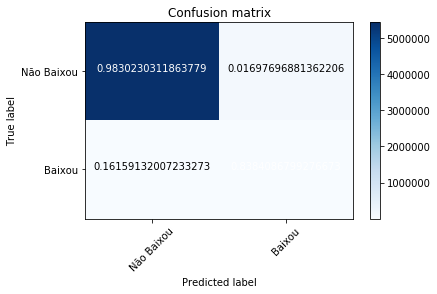

In [21]:
# Avaliando o modelo
roc_lgb_all = clf_eval(clf_lgb_all, X_testcv_all, y_testcv)

## 5. Predição

Depois de rodar o modelo escolhido na fase anterior, vamos fazer a predição do conjunto teste.

In [178]:
# Modelo escolhido
#clf_rf = clf_rf_base    # RandomForest apenas com as features originais 
#clf_rf = clf_rf_count   # RandomForest apenas com as features criadas
#clf_rf = clf_rf_all     # RandomForest com todas as features

clf_rf = clf_lgb_all     # LGBM com todas as features

In [179]:
start_time = time.time()
predictions = clf_rf.predict(df_test[all_features])
print('Predict LGBM df_test done with {} seconds'.format(time.time() - start_time))

Predict LGBM df_test done with 48.141597270965576 seconds


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 6. Submissão

In [180]:
click_id = [i for i in range(0,len(df_test))]

df_submit = pd.DataFrame()
df_submit['click_id'] = click_id
df_submit['is_attributed'] = predictions
df_submit.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [181]:
# Salvando 
df_submit.to_csv('prediction_LGBM_all.csv', index=False)